<a href="https://colab.research.google.com/github/zabir-nabil/lesion-segmentation-melanoma-tl/blob/master/X_Ray_TB_Segmentation_U-Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
print('zabiralnazi@yahoo.com')

zabiralnazi@yahoo.com


In [8]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
% cd /content/drive/My Drive/data_xray_tb/

/content/drive/My Drive/data_xray_tb


In [0]:
import numpy as np

imgs = np.load('imgs.npy')

In [15]:
imgs.shape

(138, 224, 224, 3)

In [16]:
type(imgs[0,0,0,0])

numpy.uint8

In [113]:
masks = np.load('masks.npy')
masks.shape

(138, 224, 224)

In [18]:
y = np.load('y.npy')
y.shape

(138, 2)

In [19]:
! pip install Augmentor 

In [21]:
print(imgs.shape)
print(masks.shape)

(138, 224, 224, 3)
(138, 224, 224)


In [22]:
masks = np.reshape(masks, (138,224,224))
print(masks.shape)

(138, 224, 224)


In [0]:
# need to convert to 3 channels

masks_3d = masks[:, :, :, None] * np.ones(3, dtype=int)[None, None, None, :]

In [48]:
masks_3d.shape

(138, 224, 224, 3)

In [0]:
z = []
for i in range(138):
  z.append([imgs[i,:,:,:], masks[i,:,:]])

In [84]:
print(len(z))
print(len(z[0]))
print((z[0][1].shape))

138
2
(224, 224)


In [0]:
# for testing
# Augmentor takes a list of list of numpy.ndarray for image, masks
images = [
    [imgs[0,:,:,:], masks[0,:,:]],
    [imgs[1,:,:,:], masks[1,:,:]],
    [imgs[2,:,:,:], masks[2,:,:]]

]
# Augmentor takes a list of list for labels [Not numpy.ndarray]
y_p = [[0, 1], [1, 0], [0, 1]]

In [0]:
y = y.tolist() # must convert from numpy ndarray to list

In [0]:
# augmentation
import Augmentor

p = Augmentor.DataPipeline(z, y)

p.rotate(probability=0.2, max_left_rotation=5, max_right_rotation=5)
p.flip_left_right(probability=0.2)
p.zoom_random(probability=0.1, percentage_area=0.8)
p.flip_top_bottom(probability=0.3)
p.gaussian_distortion(probability=0.05, grid_width=4, grid_height=4, magnitude=3, corner='bell', method='in', mex=0.5, mey=0.5, sdx=0.05, sdy=0.05)
p.random_brightness(probability=0.05, min_factor=0.7, max_factor=1.3)
p.random_color(probability=0.05, min_factor=0.6, max_factor=0.9)
p.random_contrast(probability=0.05, min_factor=0.6, max_factor=0.9)
p.random_distortion(probability=0.2, grid_width=4, grid_height=4, magnitude=2)



augmented_images, labels = p.sample(3000)

In [89]:
len(augmented_images)

3000

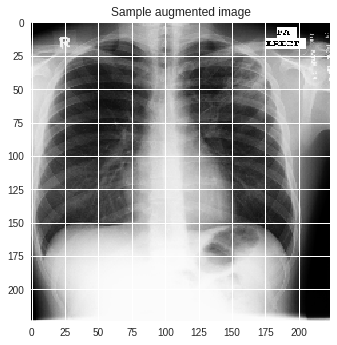

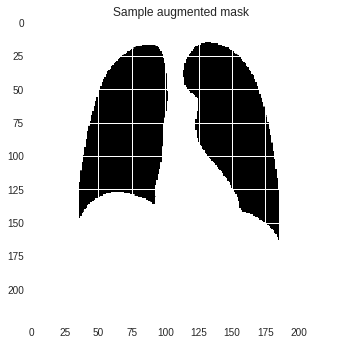

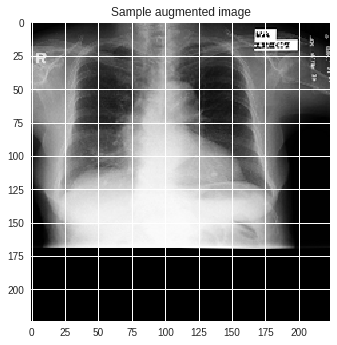

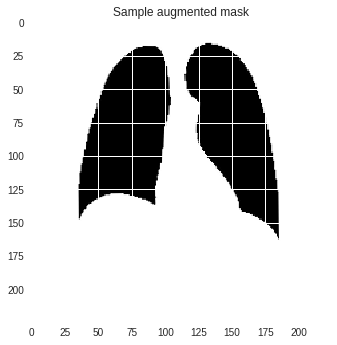

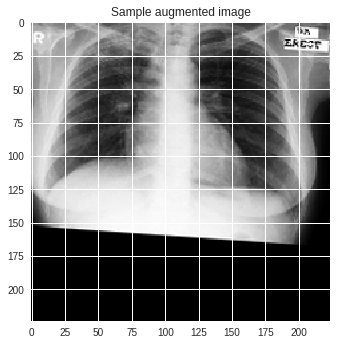

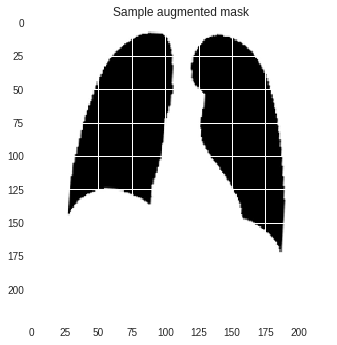

In [91]:
plt.imshow(augmented_images[500][0])
plt.title('Sample augmented image')
plt.show()

plt.imshow(augmented_images[500][1])
plt.title('Sample augmented mask')
plt.show()

plt.imshow(augmented_images[100][0])
plt.title('Sample augmented image')
plt.show()

plt.imshow(augmented_images[100][1])
plt.title('Sample augmented mask')
plt.show()

plt.imshow(augmented_images[2300][0])
plt.title('Sample augmented image')
plt.show()

plt.imshow(augmented_images[2300][1])
plt.title('Sample augmented mask')
plt.show()

In [92]:
import keras.backend as K

Using TensorFlow backend.


In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = (y_true).flatten()
    y_pred_f = (y_pred).flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    # +1 added to avoid 0/0 division
    return (2.0 * intersection + 1.0) / (np.sum(y_true_f) + np.sum(y_pred_f) + 1.0)
  
def jacard_coef(y_true, y_pred):
    y_true_f = (y_true).flatten()
    y_pred_f = (y_pred).flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (np.sum(y_true_f) + np.sum(y_pred_f) - intersection + 1.0)
  
  
def weighted_loss(y_true, y_pred):
  loss1 = dice_coef(y_true, y_pred)
  loss2 = jacard_coef(y_true, y_pred)
  return -(loss1*0.4 + loss2*0.6)

In [0]:
# updated tensor definition
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    # +1 added to avoid 0/0 division
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)
  
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)
  
  
def weighted_loss(y_true, y_pred):
  loss1 = dice_coef(y_true, y_pred)
  loss2 = jacard_coef(y_true, y_pred)
  return -(loss1*0.4 + loss2*0.6)

In [0]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.core import SpatialDropout2D, Activation
from keras import backend as K
from keras.layers.merge import concatenate
from keras.utils.data_utils import get_file

# Number of image channels (for example 3 in case of RGB, or 1 for grayscale images)
INPUT_CHANNELS = 3
# Number of output masks (1 in case you predict only one type of objects)
OUTPUT_MASK_CHANNELS = 1
# Pretrained weights


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def double_conv_layer(x, size, dropout=0.10, batch_norm=True):
    if K.image_dim_ordering() == 'th':
        axis = 1
    else:
        axis = 3
    conv = Conv2D(size, (3, 3), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = SpatialDropout2D(dropout)(conv)
    return conv


def mini_UNET(dropout_val=0.40, weights=None): # No dropout by default
    if K.image_dim_ordering() == 'th':
        inputs = Input((INPUT_CHANNELS, 224, 224))
        axis = 1
    else:
        inputs = Input((224, 224, INPUT_CHANNELS))
        axis = 3
    filters = 32

    conv_224 = double_conv_layer(inputs, filters)
    pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

    conv_112 = double_conv_layer(pool_112, 2*filters)
    pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

    conv_56 = double_conv_layer(pool_56, 4*filters)
    pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

    conv_28 = double_conv_layer(pool_28, 8*filters)
    pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

    conv_14 = double_conv_layer(pool_14, 16*filters)
    pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

    conv_7 = double_conv_layer(pool_7, 32*filters)

    up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
    up_conv_14 = double_conv_layer(up_14, 16*filters)

    up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
    up_conv_28 = double_conv_layer(up_28, 8*filters)

    up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
    up_conv_56 = double_conv_layer(up_56, 4*filters)

    up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
    up_conv_112 = double_conv_layer(up_112, 2*filters)

    up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
    up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

    conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
    conv_final = Activation('sigmoid', name='final_seg')(conv_final)
    
    
    # classification
    #flat = Flatten()(conv_7)
    #dense1 = Dense(512, activation='relu')(flat)
    #dense2 = Dense(2)(dense1)
    #class_layer = Activation('softmax', name='final_class')(dense2)
    model = Model(inputs, conv_final, name="mini_UNET")


    return model

In [99]:
model = mini_UNET()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 224, 224, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_23 (BatchNo (None, 224, 224, 32) 128         conv2d_24[0][0]                  
__________________________________________________________________________________________________
activation_23 (Activation)      (None, 224, 224, 32) 0           batch_normalization_23[0][0]     
__________________________________________________________________________________________________
conv2d_25 

In [0]:
from keras.models import load_model
from keras.optimizers import Adam
import os
from keras.losses import binary_crossentropy

out_model_path = 'unet_224_final_model.h5'
epochs = 50
patience = 20
batch_size = 64
optim_type = 'Adam'
learning_rate = 0.01

optim = Adam(lr=learning_rate)
loss={'final_seg': weighted_loss} # , 'final_class': 'binary_crossentropy'
model.compile(optimizer=optim, loss=loss, metrics=[dice_coef, 'acc'])

In [0]:
y = np.array(y, dtype='float32') # again converted to numpy array in case of classification

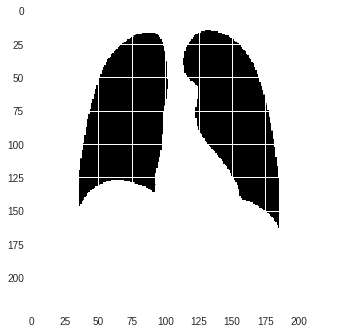

In [108]:
plt.imshow(masks[5])
plt.show()

In [109]:
augmented_images[0][1].shape

(224, 224)

In [114]:
masks.shape

(138, 224, 224)

In [115]:
imgs = np.array(imgs, dtype='float32')
masks = np.array(masks, dtype='float32')
print(imgs.shape)
masks = np.reshape(masks, (138,224,224,1))
print(masks.shape)

(138, 224, 224, 3)
(138, 224, 224, 1)


In [116]:
len(augmented_images)

3000

In [0]:
a_imgs = [a[0] for a in augmented_images]

In [118]:
print(a_imgs[0].shape)

(224, 224, 3)


In [0]:
a_masks = [a[1] for a in augmented_images]

In [120]:
print(a_masks[0].shape)

(224, 224)


In [122]:
a_imgs = np.array(a_imgs, dtype='float32')
a_masks = np.array(a_masks, dtype='float32')
a_masks = np.reshape(a_masks, (3000,224,224,1))
print(a_imgs.shape)
print(a_masks.shape)

(3000, 224, 224, 3)
(3000, 224, 224, 1)


In [125]:
a_y = np.array(labels, dtype='float32')
a_y.shape

(3000, 2)

In [126]:
f_imgs = np.concatenate((imgs,a_imgs), axis=0)
f_masks = np.concatenate((masks,a_masks), axis=0)
print(f_imgs.shape)
print(f_masks.shape)

(3138, 224, 224, 3)
(3138, 224, 224, 1)


In [127]:
print(np.max(f_imgs))
print(np.min(f_imgs))
print(np.mean(f_imgs))

print(np.max(f_masks))
print(np.min(f_masks))
print(np.mean(f_masks))

255.0
0.0
115.843
255.0
0.0
64.600655


In [128]:
f_y = np.concatenate((y,a_y), axis=0)
f_y.shape

(3138, 2)

In [0]:
f_imgs = f_imgs/255.
f_masks = f_masks/255.

In [130]:
print(np.max(f_imgs))
print(np.min(f_imgs))
print(np.mean(f_imgs))

print(np.max(f_masks))
print(np.min(f_masks))
print(np.mean(f_masks))

1.0
0.0
0.4542872
1.0
0.0
0.25333413


In [132]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-9, epsilon=0.00001, verbose=1, mode='min'),
    #EarlyStopping(monitor='val_loss', patience=patience, verbose=0),
    ModelCheckpoint('unet_224_best_weight.h5', monitor='val_loss', save_best_only=True, verbose=1),
]


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [0]:
history = model.fit(
    x = f_imgs,
    y = f_masks, #[masks,y],
    batch_size = 8,
    epochs=50,
    validation_split = 0.2,
    verbose=1,
    callbacks=callbacks)

Train on 2510 samples, validate on 628 samples
Epoch 1/50
2510/2510 [==============================] - 186s 74ms/step - loss: -0.7241 - dice_coef: 0.8000 - acc: 0.8415 - val_loss: -0.7592 - val_dice_coef: 0.8302 - val_acc: 0.8686

Epoch 00001: val_loss improved from inf to -0.75924, saving model to unet_224_best_weight.h5
Epoch 2/50
2510/2510 [==============================] - 178s 71ms/step - loss: -0.8088 - dice_coef: 0.8681 - acc: 0.8787 - val_loss: -0.8009 - val_dice_coef: 0.8623 - val_acc: 0.8812

Epoch 00002: val_loss improved from -0.75924 to -0.80089, saving model to unet_224_best_weight.h5
Epoch 3/50
2510/2510 [==============================] - 178s 71ms/step - loss: -0.8326 - dice_coef: 0.8857 - acc: 0.8868 - val_loss: -0.8184 - val_dice_coef: 0.8753 - val_acc: 0.8866

Epoch 00003: val_loss improved from -0.80089 to -0.81842, saving model to unet_224_best_weight.h5
Epoch 4/50
2510/2510 [==============================] - 178s 71ms/step - loss: -0.8507 - dice_coef: 0.8992 - acc